In [3]:
%pylab inline
import pandas as pd
import seaborn as sns
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.ensemble import RandomForestRegressor
import sys
from sklearn.model_selection import train_test_split
import pydot
#imports the own created package
import bookie_package as bp
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


In [4]:
#imports pickle file created and saved in 'load_and_clean.ipynb'
df_both_seasons_away = pd.read_pickle('df_both_seasons_essentials')

## Add avg Away Team Goal Difference

In [5]:
df_both_seasons_away.head()

,Day,Month,Year,HomeTeam,AwayTeam,FTHG,FTAG,HST,AST,HTGDIFF,ATGDIFF
151,22,12,2019,Fortuna Dusseldorf,Union Berlin,2,1,8,6,1,-1
152,22,12,2019,Paderborn,Ein Frankfurt,2,1,5,5,1,-1
145,21,12,2019,Bayern Munich,Wolfsburg,2,0,8,3,2,-2
146,21,12,2019,FC Koln,Werder Bremen,1,0,1,1,1,-1
147,21,12,2019,Mainz,Leverkusen,0,1,2,4,-1,1


In [6]:
# calculates the average away team goal difference across the last 10 hosting games
d_both_seasons = bp.averages.avg_goal_diff(df_both_seasons_away, 'AVGATGDIFF', 'AwayTeam', 'A')

In [7]:
df_both_seasons = bp.averages.from_dict_value_to_df(d_both_seasons)

In [8]:
df_both_seasons=df_both_seasons.sort_values(['Year', 'Month','Day'], ascending=False)

In [9]:
# calculates the average goals shot by the home team across the last 10 hosting games
avg_ftag_per_team=bp.averages.avg_goals(df_both_seasons, 'AVGFTAG', 'AwayTeam', 'A')

In [10]:
df_both_seasons = bp.averages.from_dict_value_to_df(avg_ftag_per_team)

In [11]:
df_both_seasons=df_both_seasons.sort_values(['Year', 'Month','Day'], ascending=False)

## Add Columns with previous AST for each AwayTeam

In [12]:
# AST values from the last ten home team games, per past match
team_with_past_AST=bp.averages.previous_data(df_both_seasons, 'AwayTeam', 'AST')

In [13]:
df_team_with_past_AST = bp.averages.from_dict_value_to_df(team_with_past_AST)

In [14]:
columns_AST = [
    'Day', 'Month', 'Year', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTGDIFF', 'ATGDIFF', 'AVGATGDIFF', 'AVGFTAG',
    'HST', 'AST', 'AST_1', 'AST_2', 'AST_3', 'AST_4', 'AST_5', 'AST_6', 'AST_7', 'AST_8', 'AST_9', 'AST_10'
    ]

In [15]:
  df_team_with_past_AST = df_team_with_past_AST.reindex(columns=columns_AST)

In [16]:
df_team_with_past_AST.sort_values(['Year', 'Month','Day'], ascending=False,inplace=True)

In [17]:
df_team_with_past_AST.fillna(0, inplace=True)

In [18]:
# FTAG values from the last ten home team games, per past match
team_with_past_FTAG = bp.averages.previous_data(df_team_with_past_AST, 'AwayTeam', 'FTAG')

In [19]:
df_team_with_past_FTAG = bp.averages.from_dict_value_to_df(team_with_past_FTAG)

In [20]:
columns_FTAG = ['FTAG_1', 'FTAG_2', 'FTAG_3', 'FTAG_4', 'FTAG_5', 'FTAG_6', 'FTAG_7', 'FTAG_8', 'FTAG_9', 'FTAG_10'] 
columns_AST_FTHG = columns_AST + columns_FTAG

In [21]:
df_team_with_past_FTAG = df_team_with_past_FTAG.reindex(columns=columns_AST_FTHG)

In [22]:
df_team_with_past_FTAG.sort_values(['Year', 'Month','Day'], ascending=False,inplace=True)

In [23]:
df_team_with_past_FTAG.fillna(0, inplace=True)

In [24]:
df_team_with_past_FTAG.columns

Index(['Day', 'Month', 'Year', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
       'HTGDIFF', 'ATGDIFF', 'AVGATGDIFF', 'AVGFTAG', 'HST', 'AST', 'AST_1',
       'AST_2', 'AST_3', 'AST_4', 'AST_5', 'AST_6', 'AST_7', 'AST_8', 'AST_9',
       'AST_10', 'FTAG_1', 'FTAG_2', 'FTAG_3', 'FTAG_4', 'FTAG_5', 'FTAG_6',
       'FTAG_7', 'FTAG_8', 'FTAG_9', 'FTAG_10'],
      dtype='object')

In [25]:
df_result = df_team_with_past_FTAG.copy()

In [26]:
df_result = df_result.drop(['HomeTeam', 'AwayTeam'], axis = 1)

In [27]:
print('Shape of features:', df_result.shape)

Shape of features: (561, 31)


## Features and Labels and Convert Data to Arrays

In [28]:
# values I want to predict
target = df_result['FTAG']

# values we want to predict and are not necessary for the random forrest regressor 
# or were identified as noise
df_result= df_result.drop([
    'Day','AST_4','AST_5','AST_3', 'AST_7', 'AST_8','AST_6',  'AST_10', 'AST_9', 'Year','FTAG','FTHG', 'HTGDIFF', 'ATGDIFF', 'HST', 'AST'
], axis = 1)

## Training and Testing Sets

In [29]:
# splitting arrays into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    df_result, target, test_size = 0.25,random_state = 42
)                       

In [30]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (420, 15)
y_train Shape: (420,)
X_test Shape: (141, 15)
y_test Shape: (141,)


## Calculate Baseline

In [31]:
# as baseline we are going to use the HomeTeam Goal averages
features_names = list(df_result.columns)
X_train = np.array(X_train)
base = X_train[:, features_names.index('AVGFTAG')]
# subtracting train result from test data
baseline_errors = abs(base - y_train)
print('MAE: ', round(np.mean(baseline_errors), 2), 'Goals.')

MAE:  1.11 Goals.


## Train Model

In [32]:
# fitting the random forrest model at the begining with 1000 estimators
rf = bp.prediction.random_forrest(X_train, y_train, n_estimators=1000,random_state = 42)

## First Predictions on Test Data

In [33]:
bp.prediction.performance_accuracy(y_test,X_test, rf)

MAE: 0.98 Goals.
regr Accuracy: 31.21 %.


In [34]:
next_games=df_result
predictions_next_games = rf.predict(next_games)
next_games_predictions=np.round(predictions_next_games,0)

In [35]:
del df_both_seasons['FTHG']

In [36]:
df_both_seasons['FTAG'] = next_games_predictions
df_both_seasons.head()

,Day,Month,Year,HomeTeam,AwayTeam,FTAG,HST,AST,HTGDIFF,ATGDIFF,AVGATGDIFF,AVGFTAG
151,22,12,2019,Fortuna Dusseldorf,Union Berlin,1.0,8,6,1,-1,-0.5,1.0
152,22,12,2019,Paderborn,Ein Frankfurt,1.0,5,5,1,-1,-0.2,1.2
145,21,12,2019,Bayern Munich,Wolfsburg,1.0,8,3,2,-2,-0.6,1.1
146,21,12,2019,FC Koln,Werder Bremen,0.0,1,1,1,-1,-0.7,1.4
147,21,12,2019,Mainz,Leverkusen,1.0,2,4,-1,1,0.5,1.9


### Single Decision Tree Visualizing 

In [37]:
rf_depth_4 = bp.prediction.random_forrest(X_train, y_train, n_estimators=10,random_state = 42, max_depth = 4)

# randomly pick one tree from ten
tree_4 = rf_depth_4.estimators_[7]

# use export_graphviz to save the tree as a dot file first as indicated: 
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
export_graphviz(tree_4, out_file = 'tree_4_away.dot', feature_names = features_names, rounded = True, precision = 1)

# then use the dot file to create a png file 
(graph, ) = pydot.graph_from_dot_file('tree_4_away.dot')
graph.write_png('tree_4_away.png');

In [38]:
print('The depth of this tree is:', tree_4.tree_.max_depth)

The depth of this tree is: 4


### Variable Importances in %

In [39]:
# creates a list of feature names and their importance
importance = np.round(rf.feature_importances_,4)
dictionary = dict(zip(features_names, importance))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
names=[]
values=[]
for i in range(0, len(importance)):
    print('Feature Importance: {:15} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: AVGATGDIFF      15.77%
Feature Importance: Month           11.48%
Feature Importance: AST_1           9.77%
Feature Importance: AVGFTAG         8.81%
Feature Importance: AST_2           8.72%
Feature Importance: FTAG_3          6.38%
Feature Importance: FTAG_1          6.2%
Feature Importance: FTAG_2          5.51%
Feature Importance: FTAG_5          5.5%
Feature Importance: FTAG_4          4.99%
Feature Importance: FTAG_7          4.78%
Feature Importance: FTAG_6          3.84%
Feature Importance: FTAG_8          2.79%
Feature Importance: FTAG_9          2.77%
Feature Importance: FTAG_10         2.69%


## Feature Reduction

In [40]:
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk')

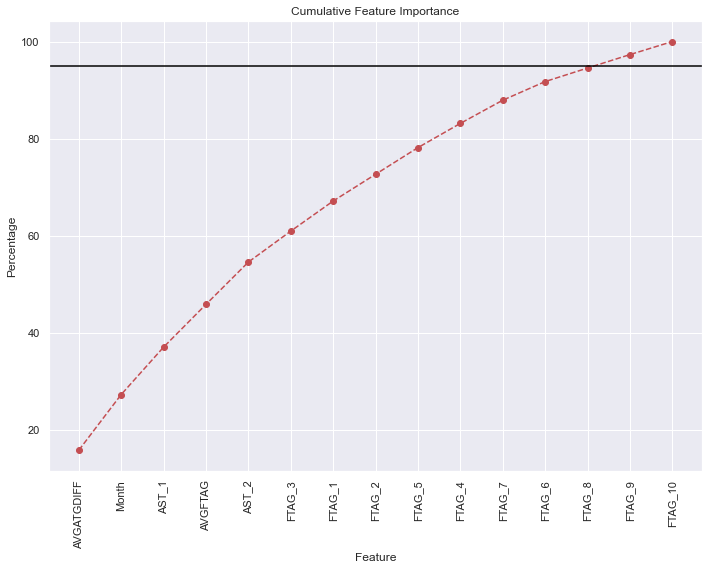

In [41]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
bottom, top = ylim()
bottom = 0
cum_values=np.cumsum(values)
plt.plot(names,cum_values, '--bo', color='r')
# set importance at 95%
plt.axhline(95,color='black')
plt.xticks(rotation=90);
plt.xlabel('Feature'); 
plt.ylabel('Percentage'); 
plt.title('Cumulative Feature Importance');

## Random Forest Optimization through Random Search

In [42]:
from sklearn.model_selection import RandomizedSearchCV
rs = bp.prediction.random_search(X_train,y_train, cv=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [43]:
best_params = rs.best_params_

In [44]:
best_params

{'n_estimators': 1000,
 'min_samples_split': 2,
 'max_leaf_nodes': 45,
 'max_features': 0.5,
 'max_depth': 19,
 'bootstrap': False}

In [45]:
# reuses newly calculated params
rfc = bp.prediction.random_forrest(
    X_train, y_train, 
    n_estimators=best_params['n_estimators'],
    random_state = 42,
    min_samples_split = best_params['min_samples_split'],
    max_leaf_nodes = best_params['max_leaf_nodes'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    bootstrap = best_params['bootstrap']
)


In [46]:
# recalculates new Mean Absolute Error and accuracy
bp.prediction.performance_accuracy(y_test,X_test, rfc)

MAE: 0.91 Goals.
regr Accuracy: 39.01 %.


In [47]:
next_games=df_result
predictions_next_games = rf.predict(next_games)
next_games_predictions=np.round(predictions_next_games,0)

In [48]:
df_both_seasons['FTAG'] = next_games_predictions
df_both_seasons.head()

,Day,Month,Year,HomeTeam,AwayTeam,FTAG,HST,AST,HTGDIFF,ATGDIFF,AVGATGDIFF,AVGFTAG
151,22,12,2019,Fortuna Dusseldorf,Union Berlin,1.0,8,6,1,-1,-0.5,1.0
152,22,12,2019,Paderborn,Ein Frankfurt,1.0,5,5,1,-1,-0.2,1.2
145,21,12,2019,Bayern Munich,Wolfsburg,1.0,8,3,2,-2,-0.6,1.1
146,21,12,2019,FC Koln,Werder Bremen,0.0,1,1,1,-1,-0.7,1.4
147,21,12,2019,Mainz,Leverkusen,1.0,2,4,-1,1,0.5,1.9


In [49]:
df_both_seasons.to_excel('df_both_seasons_away.xlsx')